# Self Organizing Map (SOM) to catch fraud customers who filed credit card applications

## Install and import relevant Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!pip install MiniSom

  Created wheel for MiniSom: filename=MiniSom-2.2.7-py3-none-any.whl size=8606 sha256=dc5abb904b798557a62276e145cc09b244b37a4d66606e1af6188288bebbd71d
  Stored in directory: /root/.cache/pip/wheels/b9/32/90/b7e7953eeb50b9880bd01bcdbf832bf9550a54d834996f858c
Successfully built MiniSom
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


## Import Dataset

In [3]:
## UCI Machine Learning Repository -- Australia Credit Card Application Data

dataset = pd.read_csv('../input/credit-card-applications/Credit_Card_Applications.csv')
# separating the variable that tells us whether the application has been approved or rejected
# this is useful for visualizing or analyzing SOM results later depending on whether application of particular customer has been approved or not
X = dataset.iloc[:, :-1].values 
y = dataset.iloc[:, -1].values #class = 1 approved ; class = 0 rejected 

## Feature Scaling

In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
X = sc.fit_transform(X)

## Training SOM

In [5]:
from minisom import MiniSom
# x,y => map size; input length = number of atrributes/variabels (in this case including customerID as well to be able to identify who's the frauder) so 15
# sigma = radius of different neighborhoods in the grid (default 1.0); higher learning rate ==> faster convergence (default 0.5)
# decay_function param not used in this example

som = MiniSom(x=10, y=10, input_len= 15, sigma= 1.0, learning_rate = 0.5)
som.random_weights_init(X) #randomly initialize the values of the weight vectors to small numbers close to 0 (but not 0)
som.train_random(data = X, num_iteration = 100)

## Visualizing Results

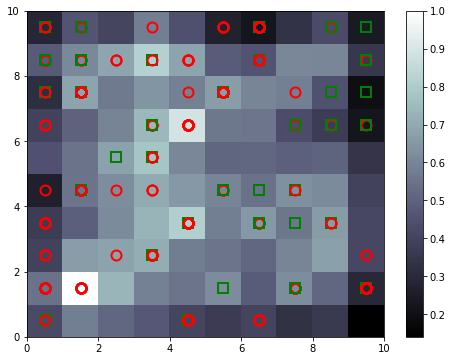

In [6]:
from pylab import bone, pcolor, colorbar, plot, show
plt.figure(figsize=(8,6))
bone() #initializing the canvas on which the visualization will be located
pcolor(som.distance_map().T) #mean inter-neuron distances in matrix ==> transpose
colorbar() #add legend
markers = ['o', 's'] #circle(rejected) and square(approved) markers
colors = ['r', 'g'] #red(rejected) and green(approved)
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5, #adding 0.5 to x and y to center the marker (otherwise the default coordinate of w will be lower left corner of grid)
         w[1] + 0.5,
         markers[y[i]], #y is the class variable from dataset (whether application got approved or rejected)
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

Each grid represents winning nodes and the color represents the inter-neuron distances of each winning node. The grids that have ligher color (as you can see from the colorbar) are likely ones who have committed fraud in credit card applications. We see some fraud customers' applications in those grids (e.g. grid(3,8) and grid(4,3) got approved and some others got rejected. We would be interested in finding these cheaters who got away with fraud detection and managed to get their applications approved.

## Finding Frauds

In [9]:
# som.win_map(X) ==> returns a defaultdictionary whose keys are the coordinates of each grid's lower left corner (winning node)
# values are the vector arrays of each customer associated with each winning node(grid)
mappings = som.win_map(X)

#grid(6,5) and grid(1,2) that had relatively light colors and had some approved applications
frauds = np.concatenate((mappings[(3,8)], mappings[(4,3)]), axis = 0) 
frauds = sc.inverse_transform(frauds) #inverse_transform cuz it has been scaled

## Printing Fraunch Clients

In [10]:
print('Fraud Customer IDs')
for i in frauds[:, 0]:
    print(int(i))

Fraud Customer IDs
15590434
15593345
15686461
15680643
15692137
15668830
15796569
15805212
15712877
15691150
15573520
15740458
15686885
15585928
15680895
15807546
15583067
15773869
15796111
15809800
15623072
15676909
15802071
15790630
15750055
15647898
15679801
15748499
15587038
15592773
15732943
15781975
15770255
15773789
15794868
15705506
15812470
15788215
15722535


In [11]:
len(frauds)

39

# Going from Unsupervised to Supervised Deep Learning

**We can use the list of customerIDs with potential fraud acquired through SOM as y (dependent variable) and train the dataset again with ANN(classification; supervised). Then, we will be able to get the supposed probability of each customer being a fradulent customer.**

## Create Matrix of Features

In [12]:
customers = dataset.iloc[:, 1:].values #second column to end (exclude first column which was customerID -- non useful info)

## Create Dependent Variable

In [24]:
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i,0] in frauds[:,0]:
        is_fraud[i] = 1

## ANN

### Feature Scaling

In [26]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

### Import Tensorflow and Initialize ANN

In [27]:
import tensorflow as tf
tf.__version__

'2.3.1'

In [28]:
ann = tf.keras.models.Sequential()

##keras
# classifier = keras.models.Sequential()

### Add input layer and first hidden layer

In [29]:
ann.add(tf.keras.layers.Dense(units=2, activation='relu'))

##keras
# classifier.add(keras.layers.Dense(units=2, kernel_intializer'uniform', activation='relu', input_dim=15)) #input_dim=15 because there are 15 independent vars 

### Add output layer

In [30]:
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

## keras
# classifier.add(keras.layers.Dense(units=1, kernel_intializer'uniform', activation='sigmoid'))

### compile ANN

In [31]:
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

## same in keras

### Train ANN on Training Set

In [32]:
ann.fit(customers, is_fraud, batch_size = 1, epochs = 5)

## same in keras

Epoch 1/5
690/690 [==============================] - 1s 775us/step - loss: 0.3794 - accuracy: 0.9406
Epoch 2/5
690/690 [==============================] - 1s 802us/step - loss: 0.2715 - accuracy: 0.9435
Epoch 3/5
690/690 [==============================] - 1s 792us/step - loss: 0.2111 - accuracy: 0.9435
Epoch 4/5
690/690 [==============================] - 1s 779us/step - loss: 0.1694 - accuracy: 0.9435
Epoch 5/5
690/690 [==============================] - 1s 817us/step - loss: 0.1423 - accuracy: 0.9435


### Predict probabilities of customers being fraud

In [33]:
y_pred = ann.predict(customers)
y_pred = np.concatenate((dataset.iloc[:, [0]].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()] #sorting by one column (in this case the second column = predicted probabilities) from lower prob to high